In [1]:
from __future__ import division
from glob import glob
from collections import defaultdict
import itertools as it

In [137]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import correlate
from scipy.ndimage import gaussian_filter
from numpy.polynomial import polynomial as poly

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc, cm

In [4]:
import tracks
reload(tracks)
import otracks
reload(otracks)

<module 'otracks' from 'otracks.pyc'>

In [5]:
import orientation as orient
reload(orient)
import correlation as corr
reload(corr)

<module 'correlation' from 'correlation.pyc'>

In [6]:
import helpy

In [7]:
rc('font', family='serif', serif=['Latin Modern', 'Computer Modern'])
rc('text', usetex=True)
smallfig = (5,4)
largefig = (8,6)

In [8]:
# Physical measurements
R_inch = 4.0           # as machined
S_measured = np.array([4,3,6,7,9,1,9,0,0,4,7,5,3,6,2,6,0,8,8,4,3,4,0,-1,0,1,7,7,5,7])*1e-4 + .309
S_inch = S_measured.mean()

# Digital measurements
R_pix = 585.5 / 2
#S_pix = 22 #ish

# What we'll use:
R = R_inch / S_inch # radius in particle units
S = R_pix/R         # particle side length in pixels
A = S**2            # particle Area
N = np.pi * R**2    # Maximum number of particles

print 'S:', S

# Time
fps = 120 #150
freq = 50 #Shaker freq 50 Hz
#nframes = 3000

S: 22.6454322917


In [9]:
locdir = '/Users/leewalsh/Physics/Squares/diffusion/orientational/'
savedir = '/Users/leewalsh/Physics/Squares/writing/graphics/'
dotfix = ''
#voltage = 50
#freq = 50
#n = 32
#prefix = 'n{}_{}mv_{}hz'.format(n, voltage, freq)
ns_all = np.unique([int(c[1:4]) for f in glob(locdir+'n???_ORIENTATION.npz') for c in f.split('/') if c.startswith('n')])
ns = ns_all
prefixer = 'n{:03d}'.format
print ns_all/N

[ 0.03047457  0.06094913  0.0914237   0.12189827  0.15237283  0.1828474
  0.21332196  0.24379653  0.2742711   0.30474566  0.33522023  0.3656948
  0.39616936  0.42664393  0.45711849  0.48759306  0.50283034  0.51806763
  0.53330491  0.54854219  0.56377948  0.57901676  0.59425404  0.60949133
  0.62472861  0.63996589  0.65520318  0.67044046  0.68567774  0.70091502
  0.71615231  0.73138959  0.74662687  0.76186416  0.77710144  0.79233872
  0.80757601  0.82281329  0.83805057  0.85328786  0.86852514  0.88376242]


In [10]:
dmin, dmax = ns.min()/N, ns.max()/N
col = lambda dens: cm.jet((dens - dmin)/(dmax - dmin))

In [11]:
def load_data(n, ret_odata=True, ret_cdata=False):
    """ Given `n`
        returns: `data`, `trackids`,[ `odata`,] `omask`,[ `cdata`]
    """
    if n==0:
        return (None,)*(3 + ret_odata + ret_cdata)
    prefix = prefixer(n)
    ret = ()

    datanpz = np.load(locdir+prefix+'_TRACKS.npz')
    ret += datanpz['data'], datanpz['trackids']

    odatanpz = np.load(locdir+prefix+'_ORIENTATION.npz')
    if ret_odata:
        ret += (odatanpz['odata'],)
    ret += (odatanpz['omask'],)

    if ret_cdata:
        cdatanpz = np.load(locdir+prefix+'_CORNER_POSITIONS.npz')
        ret += (cdatanpz['data'],)

    print 'loaded data for n =', n
    return ret

In [12]:
def load_MSD(n, pos=True, ang=True):
    """ Given `n`
        Returns `msds`, `msdids`, `msads`, `msadids`, `dtau`, `dt0`
    """
    if n==0:
        n = pos + ang
        return (None,)*(4 if n==1 else 6)
    prefix = prefixer(n)
    ret = ()
    if pos:
        msdnpz = np.load(locdir+prefix+'_MSD.npz')
        ret += msdnpz['msds'], msdnpz['msdids']
        dtau = msdnpz['dtau'][()]
        dt0 = msdnpz['dt0'][()]
    if ang:
        msadnpz = np.load(locdir+prefix+'_MSAD.npz')
        ret += msadnpz['msds'], msadnpz['msdids']
        if pos:
            assert dtau == msadnpz['dtau'][()] and dt0 == msadnpz['dt0'][()],\
                   'dt mismatch'
        else:
            dtau = msadnpz['dtau'][()]
            dt0 = msadnpz['dt0'][()]
    ret += dtau, dt0
    print 'loading MSDs for n =', n
    return ret

In [13]:
data, trackids, odata, omask = load_data(344)

loaded data for n = 344


In [14]:
msds, msdids, msads, msadids, dtau, dt0 = load_MSD(344)

loading MSDs for n = 344


using dtau = 10, dt0 = 10
using S = 1 pixels, thus A = 1 px^2


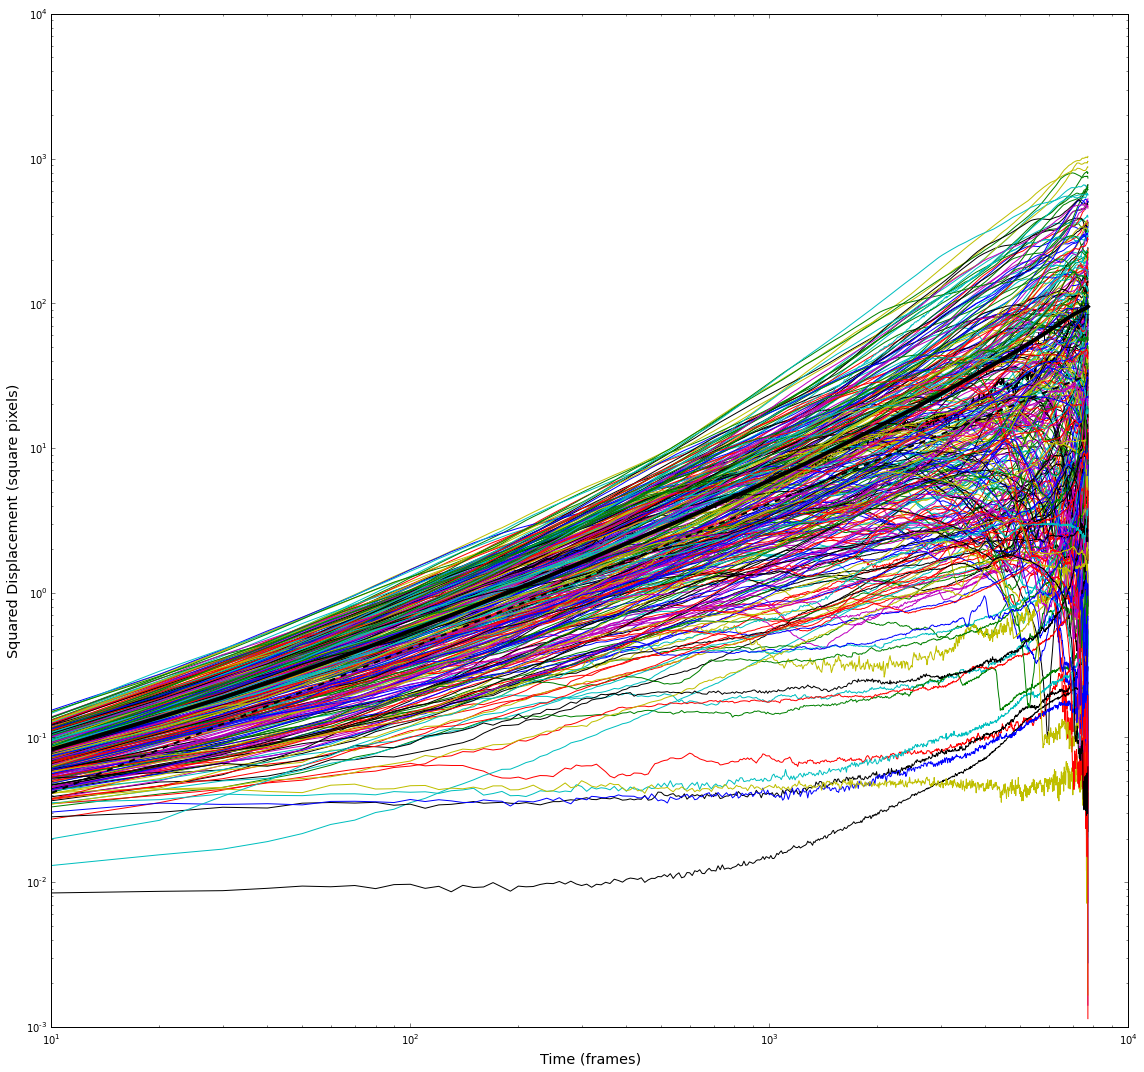

In [221]:
tracks.plot_msd(data[omask], msads, msadids, dtau, dt0, S=1, fps=1, prefix=prefix
                , figsize=(16,15), show_tracks=False, meancol='k',lw=4, errorbars=20
                , xlim=None#(dtau/fps,64)
                , ylim=None#(3e-2, 3e2)
                , title='', tnormalize=0
                , kill_flats=0.03
                , kill_jumps=.9
                , save='')#savedir+prefix+'_MSD.pdf')

# Translational MSDs

In [15]:
def diff_const(taus, msd, tau_start=None, tau_end=None, msd_err=None, fit=True, nargs=1):
    if tau_start == 'min': tau_start = np.argmin(msd/taus)
    if tau_end  ==  'min': tau_end  =  np.argmin(msd/taus)
    start = np.searchsorted(taus, tau_start) if tau_start else None
    end = np.searchsorted(taus, tau_end) if tau_end else None
    if fit:
        return curve_fit(powerlaw, taus[start:end], msd[start:end],
                         [1]*nargs, msd_err[start:end], True)
    else:
        mt = msd[start:end]/taus[start:end]
        w = 1/msd_err[start:end] if msd_err is not None else None
        d  = np.average(mt, weights=w)
        dd = np.average((mt - d)**2, weights=w)
        return d, dd

def powerlaw(t, d, b=1, c=0):
    return c + d * np.power(t, b)

In [34]:
# densities with good translational _and_ angular diffusive behavior
# for looking at MSD, MSAD simultaneously
ns_AT = np.setdiff1d(ns_all[ns_all<370], [296,328,344,352])

In [33]:
if True:
    # load all averaged MSDS
    MSDS = np.load(locdir + "MSDS.npz")
else:
    # calculate average of all MSDS
    MSDS = {}

In [11]:
# Translational kill thresholds:
kill_flats = defaultdict(lambda: 0.5, # units are pixels
                    { 16: 1, 32: 3, 48: 1, 64: 0.5, 80: 1, 96: 0.2, 112: 0.7,
                     128: 0.6, 144: 1, 160: 10, 176: 1, 192: 0.4, 336: 1,
                     360: 0.1, 368: .6, 400: 0.2, 464: 0.2 })
kill_jumps = defaultdict(lambda: 100, {})

In [16]:
# Calculate the MSDS
for n in ns_all:
    prefix = 'n{:03d}'.format(n)
    msdnpz = np.load(locdir+prefix+"_MSD.npz")
    msds = msdnpz['msds']
    if 'dt0' in msdnpz.keys():
        dt0  = msdnpz['dt0'][()] # [()] gets element from 0D array
        dtau = msdnpz['dtau'][()]
    else:
        print "assuming dt0 = dtau = 10" # ok for before dt* was saved
        dt0  = 10
        dtau = 10
    print "averaging track MSDs"
    nframes = max([np.array(msd)[:,0].max() for msd in msds]) + 1
    taus = np.arange(dtau, nframes, dtau)
    msd, msd_err = tracks.mean_msd(msds, taus, errorbars=True,
                            kill_flats=kill_flats[n],
                            kill_jumps=kill_jumps[n])
    MSDS[str(n)] = np.row_stack([taus, msd, msd_err])

averaging track MSDs


TypeError: 'NpzFile' object does not support item assignment

In [36]:
ns_T = np.asarray(MSDS.files, int); ns_T.sort()

In [37]:
# find coeffient of diffusion
ds, bs, dds, dbs = [],[],[],[]
for n in ns_T:
    taus, msd, msd_err = MSDS[str(n)] / [[fps], [A], [A]]
    tau_start = 10
    tau_end   = None
    d, dd = diff_const(taus, msd, tau_start, tau_end, msd_err, fit=True)
    if len(np.atleast_1d(d)) > 1:
        d, b = d
        dd, db = np.diag(dd)
        bs.append(b)
        dbs.append(db)
    ds.append(d)
    dds.append(dd)
ds = np.squeeze(ds)
dds = np.squeeze(dds)
if bs:
    bs = np.squeeze(bs)
    dbs = np.squeeze(dbs)

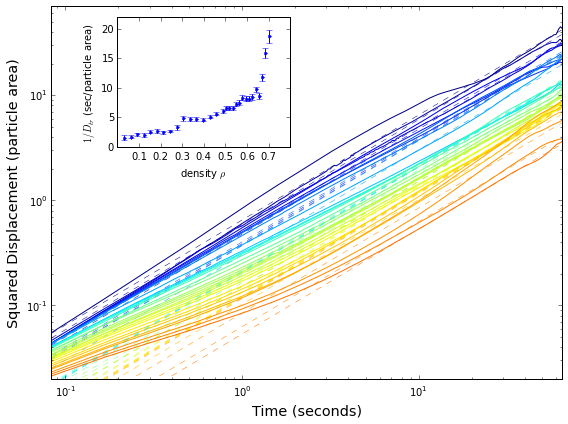

In [40]:
# Plot MSD and fits
save = False
tn = 0 # divide out this many powers of tau
flip = True # plot 1/D instead of D

rc('text', usetex=save)
dsd = 0**2 / A # uncert in squared disp (in pixels)
fig = plt.figure(figsize=largefig)#(6,5) if save else (14,10))
main = plt.gca()
inset = plt.axes([.21,.65,.3,.3])
mp = main
dp = inset
for n, d in zip(ns_T, ds):
    taus, msd, msd_err = MSDS[str(n)] / [[fps], [A], [A]]
    c = col(int(n)/N)
    mp.plot(taus, (msd-dsd)/taus**tn, c=c)
    mp.plot(taus, powerlaw(taus, d)/taus**tn,
             '--', lw=.5, c=c)
    if False:#not save: 
        label_loc = (msd/taus).argmin()
        x = taus[label_loc]
        y = msd[label_loc] / x**tn
        mp.text(x, y, n, color=c)
# plot the first one, times three, to show 'slope=1' guideline
#plt.plot(taus, 3*powerlaw(taus, ds[0]), 'k--')#, lw=.5, c=col(n/N))
mp.set_yscale('log')
mp.set_xscale('log')
tunit = 'seconds' if fps>1 else 'image frames'
yunit = 'particle area{0}' if A>1 else '$pixels^2{0}$'
yunit = yunit.format((' / '+tunit) if tn else '')
ylabel = 'Squared Displacement{} ({})'.format(' / Time' if tn else '', yunit)
mp.set_xlabel(r'Time ({})'.format(tunit), fontsize='x-large')
mp.set_ylabel(ylabel, fontsize='x-large')
mp.set_xlim(dtau/fps, taus[-1])
mp.set_ylim((.05, 1) if tn==1 else (.02,70))

D = np.reciprocal(ds) if flip else ds
dp.errorbar(ns_T/N, D, D*D*np.sqrt(dds*len(taus)), fmt='.', label='D')
dp.set_ylim(0, 22 if flip else .85)
dp.set_xticks(np.arange(.1,.8,.1))
dp.set_xlabel(r'density $\rho$')
dp.set_ylabel('${}D_{{tr}}$ ({}/{})'.format('1/' if flip else '',
                                            *['particle area', 'sec'][::-1 if flip else 1]))

if save:
    savename = savedir + "MSD{}vN.pdf".format('_t'*tn)
    # = locdir+"MSDvN_dt0=%d_dtau=%d.png"%(dt0,dtau)
    # = locdir + "MSDvN_dsd=%d.png"%dsd
    fig.savefig(savename)

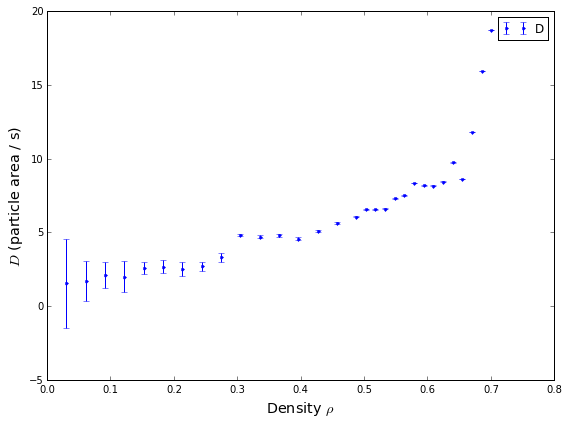

In [41]:
plt.figure(figsize=(8,6))
if bs:
    plt.errorbar(ns_T/N, bs, np.sqrt(dbs), fmt='.', label='b')
plt.errorbar(ns_T/N, 1/ds, np.sqrt(dds)*len(taus)*ds, fmt='.', label='D')
#plt.title("Constant of diffusion vs. density")
plt.xlabel(r"Density $\rho$", fontsize='x-large')
unit = '(particle area'
plt.ylabel("$D$ "+(unit+' / s)' if fps>1 else r"$pix^2/frame$"), fontsize='x-large')
#plt.ylim(0, 1)#np.max(ds)*1.2)
#plt.gca().set_yscale('log')
plt.legend(loc='best')
#plt.savefig(locdir+"DvN.pdf")#"DvN_dt0=%d_dtau=%d.png"%(dt0,dtau))

#Angular MSDs

In [42]:
if True:
    # load all averaged MSADS
    MSADS = np.load(locdir + "MSADS.npz")
else:
    # calculate average of all MSADS
    MSADS = {}

In [ ]:
# Angular:
kill_flats = defaultdict(lambda: 0, {48: 5, 344: 0.03})
kill_jumps = defaultdict(lambda: 1,
                {16: 10, 32: 5, 48: 1, 64: 2, 80: 1, 96: 1, 344: .5, 448: 0.1,
                 456: 0.1, 464: 0.1})

In [43]:
ns_A = np.asarray(MSADS.files, int)
ns_A.sort()

In [ ]:
for n in ns_A:
    prefix = 'n{:03d}'.format(n)
    msadnpz = np.load(locdir+prefix+"_MSAD.npz")
    msads = msadnpz['msds']
    if 'dt0' in msadnpz.keys():
        dt0  = msadnpz['dt0'][()] # [()] gets element from 0D array
        dtau = msadnpz['dtau'][()]
    else:
        print "assuming dt0 = dtau = 10" #  should be true for all from before dt* was saved
        dt0  = 10
        dtau = 10
    print "averaging track MSADs"
    nframes = max([np.array(msad)[:,0].max() for msad in msads]) + 1
    taus = np.arange(dtau, nframes, dtau)
    msad, msad_err = mean_msd(msads, taus, errorbars=True,
                            kill_flats=kill_flats[n],
                            kill_jumps=kill_jumps[n])
    MSADS[str(n)] = np.row_stack([taus, msad, msad_err])

In [44]:
# find coeffient of angular diffusion
das, bas, ddas, dbas = [], [], [], []
for n in ns_A:
    taus, msad, msad_err = MSADS[str(n)]
    tau_start = None
    tau_end   = 2
    d, dd = diff_const(taus/fps, msad, tau_start, tau_end, msd_err, fit=True)
    if len(np.atleast_1d(d)) > 1:
        d, b = d
        dd, db = np.diag(dd)
        bas.append(b)
        dbas.append(db)
    das.append(d)
    ddas.append(dd)
das = np.squeeze(das)
ddas = np.squeeze(ddas)
if bas:
    bas = np.squeeze(bas)
    dbas = np.squeeze(dbas)

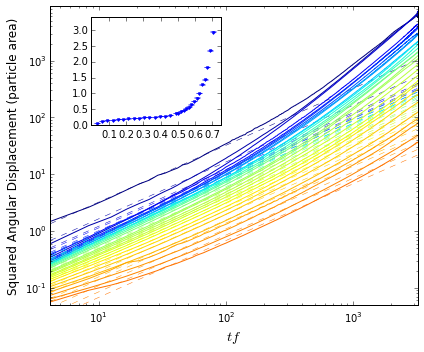

In [46]:
# Plot MSAD and fits
save = False
tn = 0 # divide out this many powers of tau
flip = True # plot 1/D instead of D

rc('text', usetex=save)
dsd = 0**2 # uncert in squared disp (in radians)
fig = plt.figure(figsize=(6,5))# if save else largefig)
main = plt.gca()
inset = plt.axes([.22,.64,.3,.3])
mp = main
dp = inset
for n, d in zip(ns_A, das):
    taus, msd, msd_err = MSADS[str(n)]
    taus = taus / fps
    c = col(int(n)/N)
    mp.plot(taus*freq, (msd-dsd)/taus**tn, c=c)
    mp.plot(taus*freq, powerlaw(taus, d)/taus**tn,
             '--', lw=.5, c=c)
    if False:#not save: 
        label_loc = (msd/taus).argmin()
        x = taus[label_loc]
        y = msd[label_loc] / x**tn
        mp.text(x, y, n, color=c)
# plot the first one, times three, to show 'slope=1' guideline
#plt.plot(taus, 3*powerlaw(taus, ds[0]), 'k--')#, lw=.5, c=col(n/N))
mp.set_yscale('log')
mp.set_xscale('log')
tunit = 'seconds' if fps>1 else 'image frames'
yunit = 'particle area{0}' if A>1 else '$pixels^2{0}$'
yunit = yunit.format((' / '+tunit) if tn else '')
ylabel = 'Squared Angular Displacement{} ({})'.format(' / Time' if tn else '', yunit)
#mp.set_xlabel(r'Time ({})'.format(tunit), fontsize='x-large')
mp.set_xlabel('$tf$', fontsize='x-large')
mp.set_ylabel(ylabel, fontsize='large')

mp.set_xlim(dtau*freq/fps, freq*taus[-1])
mp.set_ylim((.2, 200) if tn else (.05, 9e3))

D = np.reciprocal(das) if flip else das
dp.errorbar(ns_A/N, D, D*np.sqrt(ddas*len(taus)), fmt='.', label='D_ang')
dp.set_xlim(0, .75)
dp.set_ylim(0, 3.4 if flip else 18)
dp.set_xticks(np.arange(.1, .8, .1))
#dp.set_yticks(dp.get_yticks()[:-1])

if save:
    dp.set_xlabel(r'Density $\rho$')
    dp.set_ylabel('${0}D_{{ang}}$ ({1}/{2})'.format('1/' if flip else '',
                                                    *['rad$^2$', 'sec'][::-1 if flip else 1]))
    savename = savedir + "MSAD{}vN.pdf".format('_t'*tn)
    # = locdir+"MSADvN_dt0=%d_dtau=%d.png"%(dt0,dtau)
    # = locdir + "MSADvN_dsd=%d.png"%dsd
    fig.savefig(savename)

#Angular vs Translational diffusion

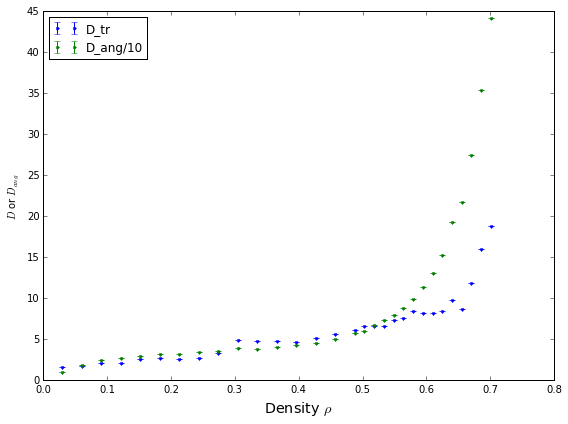

In [47]:
save = False
plt.figure(figsize=(8,6))
if bs:
    plt.errorbar(ns_T/N, bs, np.sqrt(dbs), fmt='.', label='b_tr')
    plt.errorbar(ns_T/N, bas, np.sqrt(dbas), fmt='.', label='b_ang')
plt.errorbar(ns_T/N, 1/ds, np.sqrt(dds), fmt='.', label='D_tr')
plt.errorbar(ns_A/N, 15/das, np.sqrt(ddas), fmt='.', label='D_ang/10')
plt.xlabel(r"Density $\rho$", fontsize='x-large')
plt.ylabel("$D$ or $D_{ang}$")
#plt.ylim(0, None)#np.max(ds)*1.2)
plt.legend(loc='best')
if save: plt.savefig(savedir+'Ds.pdf')

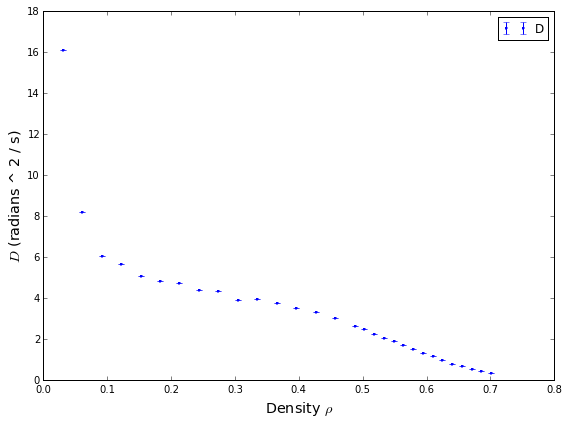

In [49]:
plt.figure(figsize=(8,6))
if bas: plt.errorbar(ns_A/N, bas, np.sqrt(dbas), fmt='.', label='b')
plt.errorbar(ns_A/N, das, np.sqrt(ddas)/fps, fmt='.', label='D', mec='none')
#plt.title("Constant of diffusion vs. density")
plt.xlabel(r"Density $\rho$", fontsize='x-large')
unit = '(radians ^ 2'
plt.ylabel("$D$ "+(unit+' / s)' if fps > 1 else unit+r"/frame)"), fontsize='x-large')
plt.ylim(0, None)#np.max(ds)*1.2)
#plt.gca().set_yscale('log')
plt.legend(loc='best')
#plt.savefig(locdir+"DAvN.pdf")#"DvN_dt0=%d_dtau=%d.png"%(dt0,dtau))

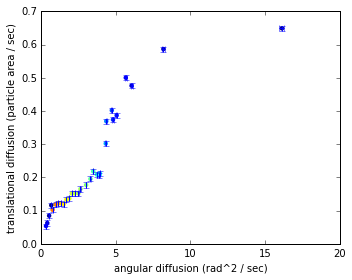

In [50]:
save = False
rc('text', usetex=save)
plt.figure(figsize=(5,4))
plt.errorbar(das, ds, np.sqrt(ddas*len(taus)), np.sqrt(dds*len(taus)), ls='', marker=',')
plt.scatter(das, ds, facecolor=col(ns_AT/N), lw=0)
plt.xlim(0, 20)
plt.ylim(0, .7)
plt.xlabel('angular diffusion (rad^2 / sec)')
plt.ylabel('translational diffusion (particle area / sec)')
if save: plt.savefig(savedir+'DvD.pdf')

In [51]:
np.intersect1d(ns_T, ns_A), ns_AT

(array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
        224, 240, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336,
        344, 352, 360, 368]),
 array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
        224, 240, 256, 264, 272, 280, 288, 304, 312, 320, 336, 360, 368]))

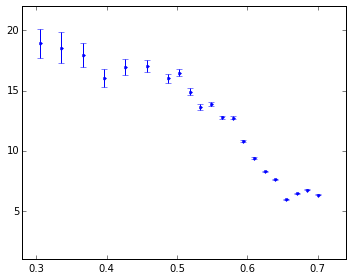

In [56]:
# Plot the Ratio of Diffusion Coefficients
# D_ratio = D_ang / D_trans
save = False
flip = False  # ang/trans unless flipped
rc('text', usetex=save)
plt.figure(figsize=(5,4))

ns = np.intersect1d(ns_T, ns_A)
iT = np.searchsorted(ns_T, ns)
iA = np.searchsorted(ns_A, ns)
ratio = das[iA]/ds[iT]
if flip: ratio = 1/ratio
plt.errorbar(ns/N, ratio, ratio*np.sqrt((dds[iT]*das[iA]**2 + ddas[iA]*ds[iT]**2)*len(taus))
             , marker='.', ls='')
if save:
    order = -1 if flip else 1
    plt.ylabel('$D_{} / D_{}$ '.format(*[r'\mathrm{ang}', r'\mathrm{tr}'][::order]) +\
               '({}/{})'.format(*['radians$^2$','particle area'][::order]),
               fontsize='x-large')
    plt.xlabel(r'Density $\rho$', fontsize='x-large')
plt.ylim((0,.2) if flip else (1, 22))
plt.xlim(.28, .74)
plt.xticks(np.arange(.3, .8, .1))
if save: plt.savefig(savedir + "D_ratio.pdf")

#Tracks

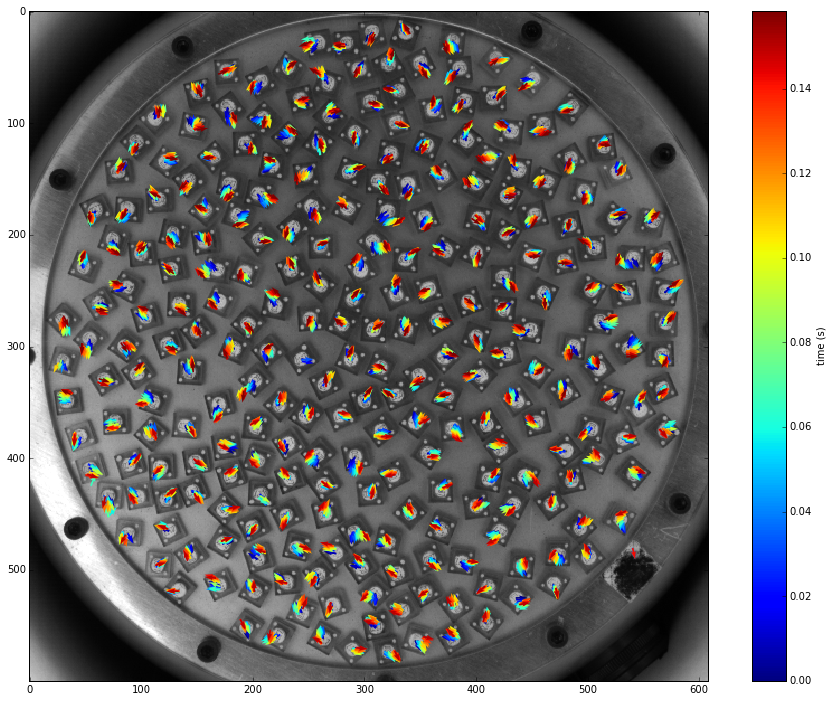

(<matplotlib.quiver.Quiver at 0x10baf63d0>,
 <matplotlib.colorbar.ColorbarBase instance at 0x10baf3f80>)

In [8]:
orient.plot_orient_quiver(data[:5000], odata[:5000], omask[:5000], imfile=locdir+prefix+'_0001.tif', fps=120,
                          figsize=(16,12), savename='')#savedir + 'quiver_tracks.png')

tracks used are set([0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34])


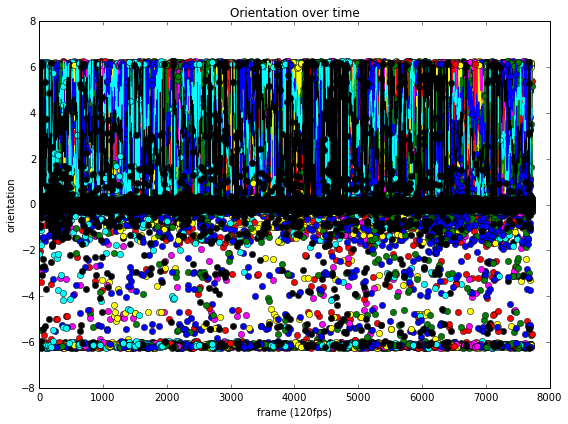

In [7]:
orient.plot_orient_time(data,odata,trackids,delta=True)#,simplify=True)

tracks used are set([0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34])


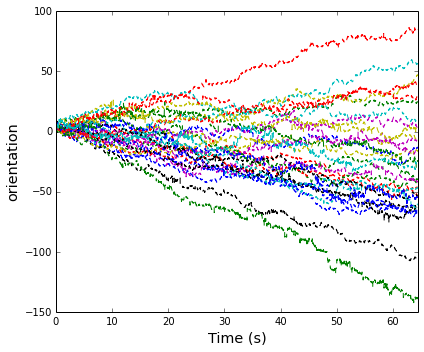

In [151]:
orient.plot_orient_time(data, odata, trackids, fps=fps, delta=False, save='savedir' + orient_tracking.pdf')

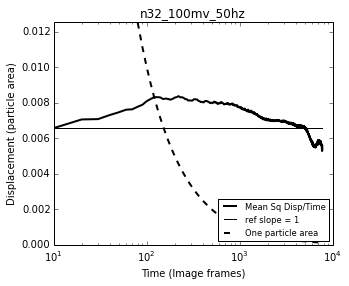

In [92]:
tracks.plot_msd(data, msds, dtau, dt0, prefix=prefix, tnormalize=1)

using dtau = 10, dt0 = 10
Rough coefficient of diffusion: 8.14727780692
Rough diffusion timescale: 0.166666666667
saving to /Users/leewalsh/Physics/Squares/writing/graphics/MSAD.pdf


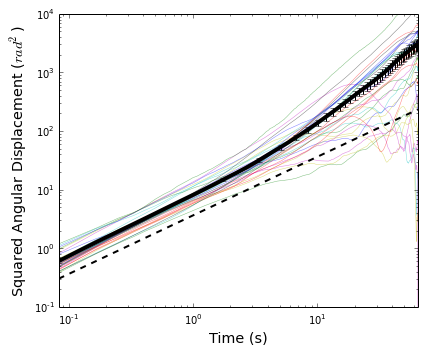

(array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
         120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
         230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
         340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
         450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
         560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
         670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
         780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
         890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
        1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100,
        1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210,
        1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320,
        1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430,
        1440, 1450, 1460, 1470, 1480, 

In [237]:
otracks.plot_msd(data[omask], msads, msadids, dtau, dt0, prefix=prefix, errorbars=20,
                 fps=fps, S=S, show_tracks=True, figsize=(6,5), meancol='k', title="", lw=4,
                 xlim=(dtau/fps, 64), ylim=(1e-1,1e4), save=savedir + 'MSAD.pdf')

using dtau = 10, dt0 = 10
Rough coefficient of diffusion: 8.14727780692
Rough diffusion timescale: 0.166666666667
saving to ../writing/graphics/MSAD.pdf


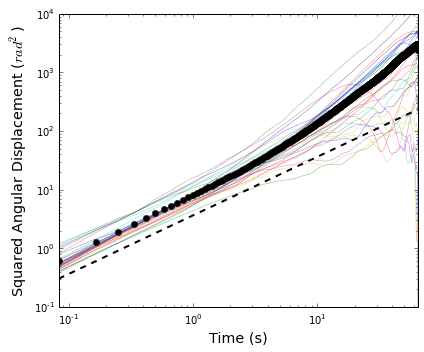

In [146]:
otracks.plot_msd(data[omask], msads, msadids, dtau, dt0, prefix=prefix,
                 fps=fps, S=S, show_tracks=True, figsize=(6,5), meancol='k', title="",
                 xlim=(dtau/fps, 64), ylim=(1e-1,1e4), save='')#savedir + 'MSAD.pdf')

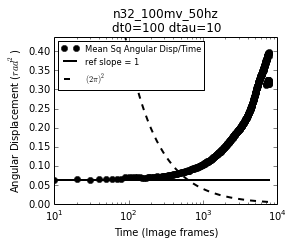

In [89]:
otracks.plot_msd(data[omask], msads, dtau, dt0, tnormalize=1, prefix=prefix, show_tracks=False)

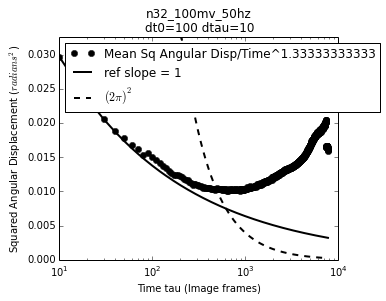

In [47]:
otracks.plot_msd(data[omask], msads, dtau, dt0, tnormalize=4./3, prefix=prefix, show_tracks=False)

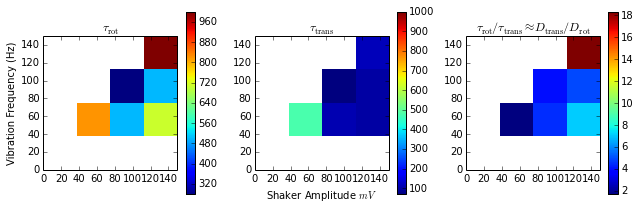

In [165]:
tau_trans = np.array([[ np.nan, np.nan, np.nan, np.nan],
                      [ np.nan, 480.,     110.,   100.],
                      [ np.nan, np.nan,    70.,   100.],
                      [ np.nan, np.nan, np.nan,   120.]])

tau_rot = np.array([[ np.nan, np.nan, np.nan, np.nan],
                    [ np.nan,   820.,   500.,   710.],
                    [ np.nan, np.nan,   280.,   500.],
                    [ np.nan, np.nan, np.nan,  2200.]])

plt.figure(figsize=(9,3))
plt.subplot(131)
plt.imshow(tau_rot,origin='lower',extent=(0,150,0,150),interpolation='nearest',vmax=1000.)
plt.title(r"$\tau_\mathrm{rot}$")
plt.ylabel('Vibration Frequency (Hz)')
plt.colorbar()
plt.subplot(132)
plt.imshow(tau_trans,origin='lower',extent=(0,150,0,150),interpolation='nearest',vmax=1000.)
plt.title(r"$\tau_\mathrm{trans}$")
plt.xlabel('Shaker Amplitude '+r'$mV$')
plt.colorbar()
plt.subplot(133)
plt.imshow(tau_rot/tau_trans,origin='lower',extent=(0,150,0,150),interpolation='nearest')
plt.title(r"$\tau_\mathrm{rot}/\tau_\mathrm{trans}\approx D_\mathrm{trans}/D_\mathrm{rot}$")
plt.colorbar()
plt.savefig(savedir + 'D_f_A.pdf')

#Order Parameters

In [57]:
# Uncomment to initiate variables
Phi = {}

In [90]:
ns_all, ns

(array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
        224, 240, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336,
        344, 352, 360, 368, 376, 384, 392, 400, 408, 416, 424, 432, 440,
        448, 456, 464]),
 array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
        224, 240, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336,
        344, 352, 360, 368]))

In [58]:
for n in ns_all:
    data, trackids, odata, omask = load_data(n)
    Phi[n] = np.array([corr.orient_op(o['orient'], d[['x','y']].view((float,2)).copy()
                                      , m=4, margin=2, ret_complex=False)
              for d, o in it.izip(helpy.splitter(data[omask], data['f'][omask]),
                                  helpy.splitter(odata[omask], data['f'][omask]))])

loaded data for n = 16
loaded data for n = 32
loaded data for n = 48
loaded data for n = 64
loaded data for n = 80
loaded data for n = 96
loaded data for n = 112
loaded data for n = 128
loaded data for n = 144
loaded data for n = 160
loaded data for n = 176
loaded data for n = 192
loaded data for n = 208
loaded data for n = 224
loaded data for n = 240
loaded data for n = 256
loaded data for n = 264
loaded data for n = 272
loaded data for n = 280
loaded data for n = 288
loaded data for n = 296
loaded data for n = 304
loaded data for n = 312
loaded data for n = 320
loaded data for n = 328
loaded data for n = 336
loaded data for n = 344
loaded data for n = 352
loaded data for n = 360
loaded data for n = 368
loaded data for n = 376
loaded data for n = 384
loaded data for n = 392
loaded data for n = 400
loaded data for n = 408
loaded data for n = 416
loaded data for n = 424
loaded data for n = 432
loaded data for n = 440
loaded data for n = 448
loaded data for n = 456
loaded data for n = 46

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)


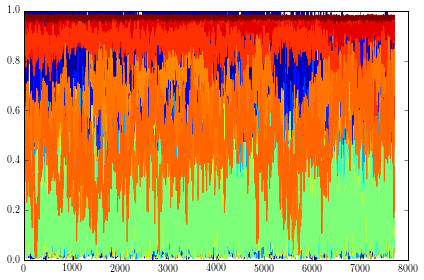

In [104]:
for n, P in reversed(Phi.iteritems()):
    plt.plot(P, color=col(n/N))

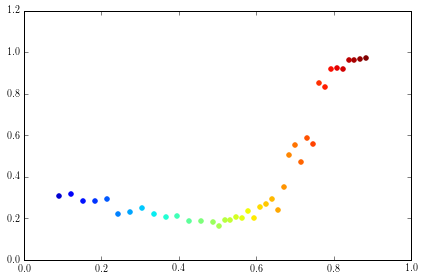

In [105]:
for n, P in Phi.iteritems():
    plt.scatter(n/N, P.mean(), color=col(n/N))

In [65]:
freq = 50

In [66]:
nframes = len(Phi[16])

In [103]:
Phi_ac = {n: autocorr(P) for n, P in Phi.iteritems()}

In [274]:
reload(corr)

<module 'correlation' from 'correlation.py'>

In [269]:
# Fit to poly_exp
Phi_ac_pe = {}
for n, Pac in Phi_ac.iteritems():
    x = np.arange(len(Pac))
    if not np.all(np.isfinite(Pac)):
        print n, 'not all finite'
        continue
    try:
        p, _ = curve_fit(corr.poly_exp, x, Pac, [1,1,1])
        Phi_ac_pe[n] = corr.poly_exp(x, *p)
    except RuntimeError:
        continue

16 not all finite
32 not all finite


In [265]:
# Gaussian smooth (low-pass)
Phi_ac_lp = {}
for n, Pac in Phi_ac.iteritems():
    #if not np.all(np.isfinite(Pac)):
    #    print n, 'not all finite'
    #    continue
    #Pac = np.maximum(Pac, 0)
    g = [gaussian_filter(Pac, sig, mode='constant', cval=Pac[sig]) for sig in (1, 10, 100, 1000)]
    Phi_ac_lp[n] = np.choose(np.repeat([0,1,2,3], [10,90,900,len(Pac)-1000]), g)

In [248]:
print ns_all

[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 264 272
 280 288 296 304 312 320 328 336 344 352 360 368 376 384 392 400 408 416
 424 432 440 448 456 464]


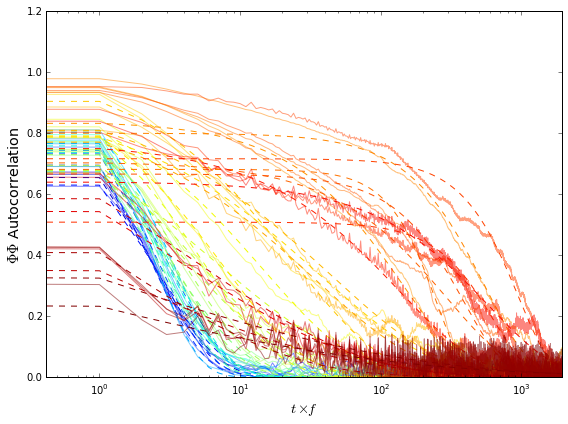

In [273]:
# Plot the Phi-Phi Autocorrelation
save = False
rc('text', usetex=save)
plt.figure(figsize=smallfig if save else largefig)
for n in ns_all:#[(ns_all>350) & (ns_all<417)]:
    Pac = Phi_ac[n]
    tf = np.arange(len(Pac))#*freq/fps
    plt.plot(tf, np.maximum(Pac,0), color=col(n/N), alpha=.5)
    try:
        plt.plot(tf, np.maximum(Phi_ac_pe[n],0), '--', color=col(n/N))
    except KeyError:
        continue
plt.yscale('linear')
plt.xscale('log')
#plt.ylim(0, 1)
plt.xlim(freq/fps, nframes/4)
plt.ylabel(r'$\Phi\Phi$ Autocorrelation', fontsize='x-large')
plt.xlabel(r'$t\times f$', fontsize='x-large')
if save: plt.savefig(savedir + "phi_autocorr.pdf")

(0.1, 0.9)

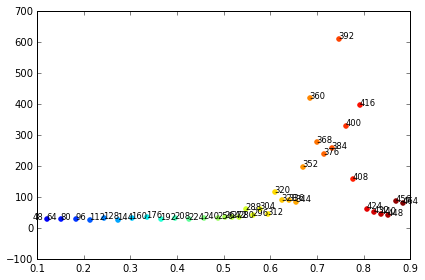

In [286]:
for n, Pac in Phi_ac.iteritems():
    if n <= 32: continue
    #tf = np.arange(len(Pac))*freq/fps
    stop = None#np.searchsorted(tf, 10)
    tau = corr.decay_scale(Pac[:stop], tf[:stop], smooth='', method='int')
    plt.scatter(n/N, tau, color=col(n/N))
    plt.text(n/N, tau, str(n), fontsize='small')
plt.xlim(.1,.9)
#plt.ylim(0, 5000)

In [64]:
Psi = {}
for n in ns_all:
    data, trackids, odata, omask = load_data(n)
    Psi[n] = np.array([corr.pair_angle_op(
                               *corr.pair_angles(d[['x','y']].view((float,2)).copy(), 4,
                                                 margin=2, dub=2*S)[:2]
                       , m=4)[0]
              for d, o in it.izip(helpy.splitter(data[omask], data['f'][omask]),
                                  helpy.splitter(odata[omask], data['f'][omask]))])

loaded data for n = 16
loaded data for n = 32
loaded data for n = 48
loaded data for n = 64
loaded data for n = 80
loaded data for n = 96
loaded data for n = 112
loaded data for n = 128
loaded data for n = 144
loaded data for n = 160
loaded data for n = 176
loaded data for n = 192
loaded data for n = 208
loaded data for n = 224
loaded data for n = 240
loaded data for n = 256
loaded data for n = 264
loaded data for n = 272
loaded data for n = 280
loaded data for n = 288
loaded data for n = 296
loaded data for n = 304
loaded data for n = 312
loaded data for n = 320
loaded data for n = 328
loaded data for n = 336
loaded data for n = 344
loaded data for n = 352
loaded data for n = 360
loaded data for n = 368
loaded data for n = 376
loaded data for n = 384
loaded data for n = 392
loaded data for n = 400
loaded data for n = 408
loaded data for n = 416
loaded data for n = 424
loaded data for n = 432
loaded data for n = 440
loaded data for n = 448
loaded data for n = 456
loaded data for n = 46

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [211]:
Psi_ac = { n: autocorr(P) for n, P in Psi.iteritems()}

In [215]:
# Gaussian smooth (low-pass)
Psi_ac_lp = {}
for n, Pac in Psi_ac.iteritems():
    #if not np.all(np.isfinite(Pac)):
    #    print n, 'not all finite'
    #    continue
    #Pac = np.maximum(Pac, 0)
    g = [gaussian_filter(Pac, sig, mode='constant', cval=Pac[sig]) for sig in (1, 10, 100, 1000)]
    Psi_ac_lp[n] = np.choose(np.repeat([0,1,2,3], [10,90,900,len(Pac)-1000]), g)

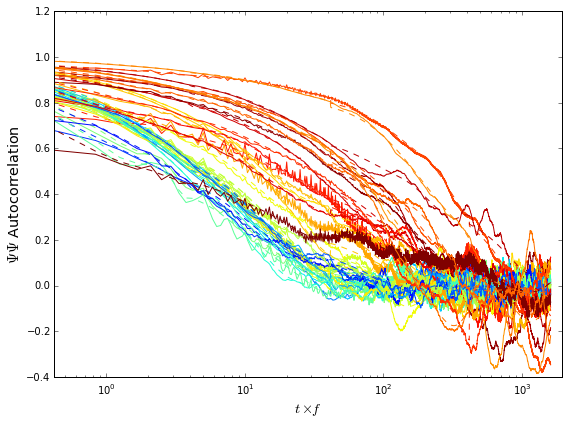

In [218]:
# Plot the Psi-Psi Autocorrelation
save = False
rc('text', usetex=save)
plt.figure(figsize=smallfig if save else largefig)
for n, Pac in Psi_ac.iteritems():
    tf = np.arange(len(Pac))*freq/fps
    plt.plot(tf, Pac, color=col(n/N))
    plt.plot(tf, Psi_ac_lp[n], '--', color=col(n/N))
plt.yscale('linear')
plt.xscale('log')
#plt.ylim(.1, 1)
plt.xlim(freq/fps, nframes/4)
plt.ylabel(r'$\Psi\Psi$ Autocorrelation', fontsize='x-large')
plt.xlabel(r'$t\times f$', fontsize='x-large')
if save: plt.savefig(savedir + "psi_autocorr.pdf")

(0.1, 0.9)

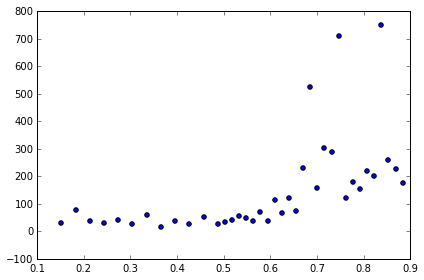

In [220]:
for n, Pac in Psi_ac.iteritems():
    #tf = np.arange(len(Pac))*freq/fps
    stop = None#np.searchsorted(tf, 20)
    tau = corr.decay_scale(Pac[:stop], tf[:stop], smooth='gaussian', method='integrated', rectify=True)
    plt.scatter(n/N, tau)
plt.xlim(.1,.9)